In [1]:
#-------------------------------------------------------
#  1 - BIBLIOTECAS
#-------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold
from imblearn.over_sampling import RandomOverSampler, SMOTE
import optuna

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)







from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

c:\Users\carol\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#-------------------------------------------------------
#  2 - PLOTANDO DAS CLASSES PARA EVIDENCIAR AS PROPORÇÕES
#-------------------------------------------------------

def plot_classes_with_proportions(df, target_column):
    # Crie o countplot
    ax = sns.countplot(x=target_column, data=df)

    # Calcule o número total de ocorrências
    total_occurrences = len(df)

    # Obtenha a contagem de ocorrências de cada classe
    class_count = df[target_column].value_counts()

    # Calcule as proporções em relação ao total de ocorrências de cada classe
    proportions = class_count / total_occurrences * 100

    # Exiba as proporções no gráfico
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{proportions[i]:.2f}%', ha='center')

    # Verifique se a proporção do desbalanceamento é menor que 40% e retorne 'true' ou 'false'
    if proportions.min() < proportionclass:
        return True
    else:
        return False

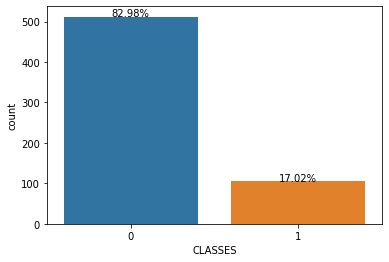

In [3]:
#-------------------------------------------------------
# 3 - LEITURA DOS DADOS E ALGUNS PARÂMETROS DO CÓDIGO
#-------------------------------------------------------
#BASE DE DADOS:
df = pd.read_csv("C:/Users/carol/Dropbox/UFRGS/python portfolio/df_pre_processado.csv")
#COLUNA DA BASE DE DADOS QUE CORRESPONDE A VARIÁVEL A SER PREVISTA:
target_column = 'CLASSES'
#TÉCNICA DE ESCALONAMENTO A SER UTILIZADA:
#opções = 'min_max', 'z_score'
scaling_method = 'min_max'
#PROPORÇÃO (%) DE DESBALANCEAMENTO ENTRE AS CLASSES ACEITÁVEL PARA A NÃO APLICAÇÃO DE TÉCNICAS QUE REALIZAM O BALANCEAMENTO DOS DADOS
proportionclass = 40
# CASO OS DADOS ESTEJAM DESBALANCEADOS, imbalanced_classes IRÁ RETORNAR O PARÂMETRO 'true' QUE PERMITE QUE O CÓDGIO FAÇA O BALANCEAMENTO:
#opções = 'true', 'false'
imbalanced_classes = plot_classes_with_proportions(df, target_column)
# CASO OS DADOS ESTEJAM DESBALANCEADOS, ESCOLHA A TÉCNICA PARA BALANCEAMENTO DOS DADOS:
#opções = 'RandomUnderSampler', 'InstanceHardnessThreshold', 'RandomOverSampler', 'SMOTE'
res_technique = 'InstanceHardnessThreshold'

In [4]:
#-------------------------------------------------------
# 4 - DIVISÃO DOS DADOS EM X E Y
#-------------------------------------------------------

def split_df_into_target_and_features(df, target_column):
    df_y = df[target_column]
    df_y= df_y.to_numpy()
    df_x = df.drop(target_column, axis=1)
    return df_x, df_y

In [5]:
#---------------------------------------------------------
# 5 - Escalonamento: NORMALIZAÇÃO ou PADRONIZAÇÃO
#---------------------------------------------------------

def scaling(df_x, scaling_method):
    if scaling_method == 'min_max':
        min_max_scaler = MinMaxScaler(feature_range=(0,1))
        x_normalized = min_max_scaler.fit_transform(df_x)
        return x_normalized
    elif scaling_method == 'z_score':
        z_scaler = StandardScaler()
        x_normalized = z_scaler.fit_transform(df_x)
        return z_scaler
    else:
        raise ValueError("Método de normalização não reconhecido. Use 'min_max' ou 'z_score'.")   

In [6]:
#---------------------------------------------------------
# 6 - METRICAS DE AVALIAÇÃO DOS DADOS
#---------------------------------------------------------
# os dados de entrada são os dados reais de saída (y_true) e os dados previstos para as respectivas saídas (y_pred)
def classification_metrics(y_true, y_pred):

    # Calcula as métricas individualmente
    acuracia = sklearn.metrics.accuracy_score(y_true, y_pred)
    precisao = sklearn.metrics.precision_score(y_true, y_pred)
    recall = sklearn.metrics.recall_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    auc = sklearn.metrics.roc_auc_score(y_true, y_pred)
    #retorna todas as métricas calculadas
    return acuracia, precisao, recall, f1_score, auc

In [7]:
#---------------------------------------------------------
# 7 - BALANCEAMENTO DOS DADOS
#---------------------------------------------------------
def resampling(df_x, df_y, res_technique):
    if res_technique == 'RandomUnderSampler':
        balancer = RandomUnderSampler()
    elif res_technique == 'InstanceHardnessThreshold':
        balancer = InstanceHardnessThreshold()
    elif res_technique == 'RandomOverSampler':
        balancer = RandomOverSampler()
    elif res_technique == 'SMOTE':
        balancer = SMOTE()
    else:
        raise ValueError('Técnica de balanceamento não reconhecida.')
    
    balanced_x, balanced_y = balancer.fit_resample(df_x, df_y)
    counts = np.bincount(balanced_y)
    
    return balanced_x, balanced_y

In [8]:
#---------------------------------------------------------
# 8 - BALANCEAMENTO DOS DADOS, se 'imbalanced_classes' for 'true'
#---------------------------------------------------------

# Função para resample dos dados caso 'imbalanced_classes' seja 'true'
def resampling_if_imbalanced_classes_is_true(X_train, y_train, res_technique, imbalanced_classes):
    if imbalanced_classes == True:
        # Aplique a função criada anteriormente, de resampling tecnique, apenas no conjunto de treinamento do fold atual
        balanced_x, balanced_y = resampling(X_train, y_train, res_technique)
        return balanced_x, balanced_y
    
    else:
        return X_train, y_train


Optuna é uma biblioteca Python robusta e de código aberto desenvolvida para simplificar a otimização de hiperparâmetros no aprendizado de máquina. Ele oferece uma interface intuitiva para otimizar hiperparâmetros, permitindo que você explore com eficiência o vasto espaço de pesquisa e determine a configuração ideal para o seu modelo. A principal funcionalidade do Optuna reside em sua capacidade de procurar automaticamente os melhores hiperparâmetros através de vários algoritmos de otimização e estratégias de poda.

In [9]:
def objective_knn(trial, df_x, df_y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 15, step=2)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

    cv_scores = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(df_x, df_y):
        X_train_fold, X_val_fold = df_x[train_index], df_x[val_index]
        y_train_fold, y_val_fold = df_y[train_index], df_y[val_index]
        
        # Aplicando a função criada anteriormente, de resampling tecnique if_imbalanced_classes_is_true, apenas no conjunto de treinamento do fold atual
        returned_x, returned_y = resampling_if_imbalanced_classes_is_true(X_train_fold, y_train_fold, res_technique, imbalanced_classes)

        # Criando o modelo KNN com os hiperparâmetros
        model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        # Treinando o modelo no conjunto de treinamento, após aplicar resampling_if_imbalanced_classes_is_true
        model.fit(returned_x, returned_y)
        # Avaliando o modelo no conjunto de validação atual
        y_pred = model.predict(X_val_fold)

        # Calculando a métrica de avaliação (AUC) para este fold, (observe que eu deixei a métrica hardcodada nessa parte do código, é possível deixar isso mais flexível)
        f1 = sklearn.metrics.f1_score(y_val_fold, y_pred)
        # Armazene a métrica no fold atual
        cv_scores.append(f1)
    # Calcule a média das métricas de validação cruzada
    avg_cv_score = np.mean(cv_scores)

    return avg_cv_score


# def objective_svm(trial, df_x, df_y):
#     C = trial.suggest_loguniform('C', 0.1, 10)
#     kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

#     model = SVC(C=C, kernel=kernel)

#     cv_scores = []
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for train_index, val_index in kf.split(df_x, df_y):
#         X_train_fold, X_val_fold = df_x[train_index], df_x[val_index]
#         y_train_fold, y_val_fold = df_y[train_index], df_y[val_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_val_fold)

#         f1 = sklearn.metrics.f1_score(y_val_fold, y_pred)
#         cv_scores.append(f1)

#     avg_cv_score = np.mean(cv_scores)

#     return avg_cv_score


# def objective_randomforest(trial, df_x, df_y):
#     n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

#     model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

#     cv_scores = []
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     for train_index, val_index in kf.split(df_x, df_y):
#         X_train_fold, X_val_fold = df_x[train_index], df_x[val_index]
#         y_train_fold, y_val_fold = df_y[train_index], df_y[val_index]

#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_val_fold)

#         f1 = sklearn.metrics.f1_score(y_val_fold, y_pred)
#         cv_scores.append(f1)

#     avg_cv_score = np.mean(cv_scores)

#     return avg_cv_score


In [10]:
def optimize_hyperparameters(df_x, df_y, model_type, n_trials):
    if model_type == 'KNN':
        objective = objective_knn
    elif model_type == 'SVM':
        objective = objective_svm
    elif model_type == 'RandomForest':
        objective = objective_randomforest
    #estudo Optuna com uma estratégia de poda
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective(trial, df_x, df_y), n_trials=n_trials)

    best_params = study.best_params

    return best_params

In [11]:
#aplicando as funções criadas anteriormente, primeiro para dividir o df em x(variáveis independentes) e y(variável dependente), e depois aplicando a função de escalonamento dos dados
df_x, df_y = split_df_into_target_and_features(df, target_column)
df_x = scaling(df_x, scaling_method)

In [12]:
best_params_knn = optimize_hyperparameters(df_x, df_y, 'KNN', n_trials=100)
# best_params_svm = optimize_hyperparameters(df_x, df_y, 'SVM', n_trials=40)
# best_params_randomforest = optimize_hyperparameters(df_x, df_y, 'RandomForest', n_trials=40)

print("Melhores parâmetros para KNN:", best_params_knn)
# print("Melhores parâmetros para SVM:", best_params_svm)
# print("Melhores parâmetros para RandomForest:", best_params_randomforest)

[I 2024-03-04 10:34:41,814] A new study created in memory with name: no-name-d9dcdea2-515e-48e4-a916-975ce34ad91b
[I 2024-03-04 10:34:44,808] Trial 0 finished with value: 0.3713501209275857 and parameters: {'n_neighbors': 1, 'metric': 'minkowski'}. Best is trial 0 with value: 0.3713501209275857.
[I 2024-03-04 10:34:47,569] Trial 1 finished with value: 0.3534844734844734 and parameters: {'n_neighbors': 1, 'metric': 'euclidean'}. Best is trial 0 with value: 0.3713501209275857.
[I 2024-03-04 10:34:50,312] Trial 2 finished with value: 0.4029450522595684 and parameters: {'n_neighbors': 5, 'metric': 'minkowski'}. Best is trial 2 with value: 0.4029450522595684.
[I 2024-03-04 10:34:52,874] Trial 3 finished with value: 0.3729896108965195 and parameters: {'n_neighbors': 11, 'metric': 'euclidean'}. Best is trial 2 with value: 0.4029450522595684.
[I 2024-03-04 10:34:55,440] Trial 4 finished with value: 0.3719571948998178 and parameters: {'n_neighbors': 11, 'metric': 'euclidean'}. Best is trial 2 w

Melhores parâmetros para KNN: {'n_neighbors': 7, 'metric': 'minkowski'}


In [13]:
best_params_knn

{'n_neighbors': 7, 'metric': 'minkowski'}